### The following techniques will be used in this notebook- 

1. Logistic regression <br>
2. K nearest neighbors <br>
3. Support vector machines (linear, gaussian and hyperparameter tuning) <br>
4. Decision Trees

In [1]:
'''
    ----------------------------------------------------------------------------------------------
    February 2022
    Dr. Kamanasish Debnath
    Postdoctoral Researcher
    Wallenberg Center for Quantum Technology (WACQT)
    Chalmers University of Technology
    
    kamanasish.debnath@gmail.com
    Data set used: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
    ----------------------------------------------------------------------------------------------
    
    
    In this notebook we are using Airline Passenger Satisfaction data set where the 
    satisfaction level of a customer was registered based on their gender, age, customer type, 
    and how they rated different aspects of the flight such as distance travelled, food and drinks, 
    entertainment, on-board service, legroom etc.
    
    
    We plan to employ classification models such as logistic regression, 
    K nearest neighbors and Decision Trees to come up with a model which
    can predict the customer satisfaction.
    
    
    So the work plan is as follows- 
    1. Data exploration and data cleaning.
    2. Label encoding for the relevant object data types.
    3. Check skewness of the data set and remove possible outliers.
    4. Logistic Regression
    5. K nearest neighbors
    6. Support Vector Machines
    7. Decision Trees
    
''';

In [2]:
# Import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

In [98]:
def encoding(DS, cols):
    '''
    This function takes the data set and column indexes as input which needs to be label encoded.
    Only label encoding is presently incorporated.
    
    For Object data types with only two classes, Label Encoding will be used and for columns with more
    than two classes one hot encoding will be used
                
    Arguments- 
        DS   :  The data set
        cols :  Index of the columns which needs to be encoded
               
    Returns-
        df   : Encoded data set 
    '''

    num_of_cols = len(cols)
    le = LabelEncoder()
    name_list = DS.columns[cols]
    for i in range(num_of_cols):
        
        ncases = DS[name_list[i]].value_counts().unique()
        # If the number of non numeric data types is 1 or 2 then do Label Encoding
        if len(ncases)<=2:
            DS[name_list[i]] = le.fit_transform(DS[name_list[i]])
        
        # Else create new columns using dummies
        else:
            DS = pd.get_dummies(DS, columns=[name_list[i]])

    return DS





def Scaler(df, Stype):
    
    '''
    This function does scaling of the dataframe and return the dataframe
    with scaled values.
    Two possible options - "Minmax" for MinMax scaler and "Stand" for Standard scaler
    
    Arguments-
        df          : Dataframe
        Stype       : Type of scaler - MinMax or Standard Scaler
        
    Returns-
        df          : Updated dataframe with scaled values for the numeric columns
      
    '''
    num_cols = df.columns[np.where(df.dtypes != object)]
    if Stype == 'MinMax':
        sc = MinMaxScaler()
        df[num_cols] = sc.fit_transform(df[num_cols])  
        
        
    elif Stype == 'Stand':
        sc = StandardScaler()
        df[num_cols] = sc.fit_transform(df[num_cols]) 
        
    else:
        print("Stype not matching... Applying Standard Scaler")
        sc = StandardScaler()
        df[num_cols] = sc.fit_transform(df[num_cols])
           
    return df



def LogReg(X_train, Y_train, X_test, Y_test, solver='liblinear'):
    '''
    This function takes the train and test data set and returns the predicted Y values
    and other error metrics such as mean squared error and R squared error.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory
        solver                             : If anything specific, otherwise uses liblinear
    
    Returns-
        Y_pred                             : Predicted Y
        accuracy_score                     : Accuracy score
        roc_auc_score                      : ROC_AUC score
        cmatrix                            : Confusion matrix
        fmodel                             : Fitted model

    '''
    
    
    # Standard logistic regression
    lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)   
    acc_score = accuracy_score(Y_test, Y_pred)
    ARo_score = roc_auc_score(Y_test, Y_pred, average='weighted')
    cmatrix = confusion_matrix(Y_test, Y_pred)
    fmodel = lr
    
    return Y_pred, acc_score, ARo_score, cmatrix, fmodel




def Kmeans(X_train, Y_train, X_test, Y_test, n_nbrs = 5):  
    '''
    This function takes the train and test data set and returns the predicted Y values
    and other error metrics such as mean squared error and R squared error using K means
    neighboring.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory
        n_nbrs                             : Number of neighbors to use 
    
    Returns-
        Y_pred                             : Predicted Y
        accuracy_score                     : Accuracy score
        roc_auc_score                      : ROC_AUC score
        cmatrix                            : Confusion matrix
        fmodel                             : Fitted model

    '''
    
    knn = KNeighborsClassifier(n_neighbors = n_nbrs)
    knn = knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    
    acc_score = accuracy_score(Y_test, Y_pred)
    ARo_score = roc_auc_score(Y_test, Y_pred, average='weighted')
    cmatrix = confusion_matrix(Y_test, Y_pred)
    fmodel = knn
    
    return Y_pred, acc_score, ARo_score, cmatrix, fmodel




def _SVM(X_train, Y_train, X_test, Y_test):  
    '''
    This function takes the train and test data set and returns the predicted Y values
    and other error metrics such as mean squared error and R squared error using the 
    technique of Support Vector Machine.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory

    Returns-
        Y_pred                             : Predicted Y
        accuracy_score                     : Accuracy score
        roc_auc_score                      : ROC_AUC score
        cmatrix                            : Confusion matrix
        fmodel                             : Fitted model

    '''
    
    LSVC = LinearSVC()
    LSVC = LSVC.fit(X_train, Y_train)
    Y_pred = LSVC.predict(X_test)
    
    acc_score = accuracy_score(Y_test, Y_pred)
    ARo_score = roc_auc_score(Y_test, Y_pred, average='weighted')
    cmatrix = confusion_matrix(Y_test, Y_pred)
    fmodel = LSVC
    
    
    return Y_pred, acc_score, ARo_score, cmatrix, fmodel




def _decisiontrees(X_train, Y_train, X_test, Y_test, mdepth = None):
    
    '''
    This function takes the train and test data set and returns the predicted Y values
    and other error metrics such as mean squared error and R squared error using Decision 
    Trees.
    
    Arguments-
        X_train, Y_train, X_test, Y_test   : Self explanatory
        mdepth                             : Maximum depth, if unspecified then the nodes are expanded till 
                                                all nodes are pure.

    Returns-
        Y_pred                             : Predicted Y
        accuracy_score                     : Accuracy score
        roc_auc_score                      : ROC_AUC score
        cmatrix                            : Confusion matrix
        fmodel                             : Fitted model

    '''
        
    dt = DecisionTreeClassifier(max_depth = mdepth)
    dt = dt.fit(X_train, Y_train)
    Y_pred = dt.predict(X_test)
    acc_score = accuracy_score(Y_test, Y_pred)
    ARo_score = roc_auc_score(Y_test, Y_pred, average='weighted')
    cmatrix = confusion_matrix(Y_test, Y_pred)
    fmodel = dt
    
    return Y_pred, acc_score, ARo_score, cmatrix, fmodel


In [4]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
df = pd.concat([train_set, test_set])

# Before we start, we would remove some of the irrelevant features from the data set such as ID etc.
df = df.drop(columns=['Unnamed: 0','id'], axis = 1)
df = df.reset_index()

df.head(8)

,index,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,...,5,5,5,5,4,5,4,4,0.0,satisfied


In [5]:
'''
    The useful non numeric features such as type of travel, gender, customer type etc. 
    has to be converted into numeric values.
    
    However, when the number of possible cases per column is 2 then that can be represented by
    0 and 1 in the same column.
    
    As the number of possible cases increase, e.g. 'Class' here has 3 possible options- Business, Eco 
    and Eco Plus and thus it becomes relevant to add those as separate features which is useful while fitting
    the data.
    
    The function "encoding" takes care of such cases and return a transformed dataframe.

'''

cols = np.where(df.dtypes == object)[0]
df = encoding(df, cols)

# Shuffling the feature "satisfaction" at the end of the DataFrame
cols_at_end = ['satisfaction']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]

In [6]:
# Scale the data frame using MinMax Scaler
df.iloc[:,0:len(df.columns)-1] = Scaler(df.iloc[:,0:len(df.columns)-1], 'MinMax')

In [7]:
# This checks the number of NaN values in each columns
# ONly 
print("Number of NaN values in each feature columns- ")
df.isnull().sum()

Number of NaN values in each feature columns- 


index                                  0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
Class_Business                         0
Class_Eco                              0
Class_Eco Plus  

In [8]:
# Number rows with NaN values = 393 out of 129880 
# We can safely drop those rows with NaN entries 
df = df.dropna()
df = df.reset_index()

In [9]:
# We split the data set into train and test using StratifiedShuffleSplit 
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[df.columns[:-1]], df.satisfaction))

# Create the dataframes
X_train = df.loc[train_idx, df.columns[:-1]]
Y_train = df.loc[train_idx, 'satisfaction']

X_test  = df.loc[test_idx, df.columns[:-1]]
Y_test  = df.loc[test_idx, 'satisfaction']

## LOGISTIC REGRESSION

In [114]:
Y_pred_LR, acc_score_LR, roc_auc_score_LR, cmatrix_LR, fmodel_LR = LogReg(X_train, Y_train, X_test, Y_test)

y_pred_proba = fmodel_LR.predict_proba(X_test)[::,1]
fpr_LR, tpr_LR, _ = roc_curve(Y_test, y_pred_proba)

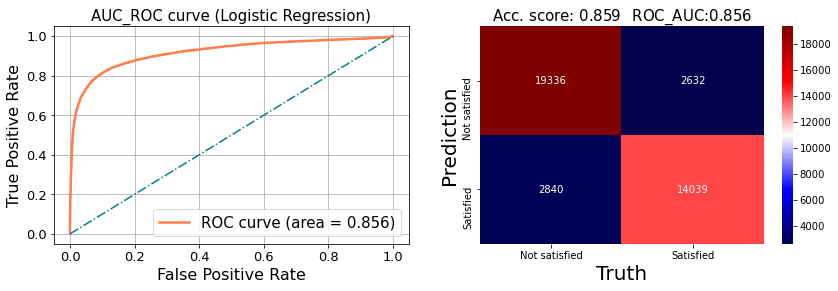

In [115]:
# Visualize the Confusion Matrix and check the accuracy score and ROC_AUC curve

fig, axs = plt.subplots(1, 2, figsize=(14, 4))


axs[0].plot(fpr_LR , tpr_LR , color='coral', linewidth = 2.5, label="ROC curve (area = %0.3f)" % roc_auc_score_LR)
axs[0].plot(fpr_LR , fpr_LR , linestyle='-.', color = 'teal')
axs[0].grid('on')
axs[0].set_ylabel('True Positive Rate', fontsize = 16)
axs[0].set_xlabel('False Positive Rate', fontsize = 16)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].set_title('AUC_ROC curve (Logistic Regression)', fontsize = 15)
axs[0].legend(fontsize = 15);



labX = ["Not satisfied", "Satisfied"]
sns.heatmap(cmatrix_LR, annot=True, fmt="d", cmap="seismic", xticklabels = labX, yticklabels = labX)
plt.title('Acc. score: '+ str(np.round(acc_score_LR,3))+ r'$\:\:$ ROC_AUC:'+ \
          str(np.round(roc_auc_score_LR,3)), fontsize = 15);
plt.xlabel('Truth', fontsize = 20)
plt.ylabel('Prediction', fontsize = 20);

In [16]:
'''
    It would be interesting to check which of the features play the most important role
    in determining customer satisfaction.
    
    As can be seen from the table below, features such as "online boarding", "Inflight wifi service", 
    "Inflight entertainment", "On-board service" and "Cleanliness" ranks in the top 5 priorities in determining customer satisfaction.

'''
temp_data = {'Features':  (df.columns[:-1]),
        'Coefficients': fmodel_LR.coef_[0]}

pd.DataFrame(temp_data).sort_values(by=['Coefficients'], ascending = False).head(8)

,Features,Coefficients
12,Online boarding,1.212201
7,Inflight wifi service,0.913697
14,Inflight entertainment,0.745647
15,On-board service,0.466342
20,Cleanliness,0.404930
16,Leg room service,0.399857
17,Baggage handling,0.355350
13,Seat comfort,0.329055


## K nearest neighbors

In [17]:
'''
    In this section we will use K nearest neighbors to predict satisfaction level of the airline customers
    based on various airline features.

'''

'\n    In this section we will use K nearest neighbors to predict satisfaction level of the airline customers\n    based on various airline features.\n\n'

In [23]:
# First we would like to check for which value of K the model gives maximum accuracy score

Error_Kmeans = []
Aro_score_Kmeans = []
X_axis = []
for i in range(1,21):
    result = Y_pred, acc_score, ARo_score, cmatrix, fmodel = Kmeans(X_train, Y_train, X_test, Y_test, n_nbrs = i)
    Error_Kmeans.append(1 - result[1])
    Aro_score_Kmeans.append(result[2])
    X_axis.append(i)
    print(i, "of", np.max(range(1,21)), "completed")

1 of 20 completed
2 of 20 completed
3 of 20 completed
4 of 20 completed
5 of 20 completed
6 of 20 completed
7 of 20 completed
8 of 20 completed
9 of 20 completed
10 of 20 completed
11 of 20 completed
12 of 20 completed
13 of 20 completed
14 of 20 completed
15 of 20 completed
16 of 20 completed
17 of 20 completed
18 of 20 completed
19 of 20 completed
20 of 20 completed


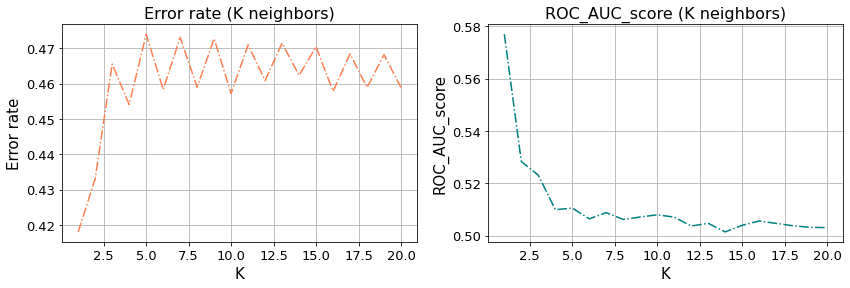

In [24]:
# Visualization of the errors for different values of K to find the most optimal value.
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(X_axis, Error_Kmeans, linestyle='-.', color = 'coral', linewidth = 1.5)
axs[0].set_ylabel('Error rate', fontsize = 15)
axs[0].set_xlabel('K', fontsize = 15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].grid('on')
axs[0].set_title("Error rate (K neighbors)", fontsize = 16)


axs[1].plot(X_axis, Aro_score_Kmeans, linestyle='-.', color = 'teal', linewidth = 1.5)
axs[1].set_ylabel('ROC_AUC_score', fontsize = 15)
axs[1].set_xlabel('K', fontsize = 15)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].tick_params(axis='y', labelsize=13)
axs[1].grid('on')
axs[1].set_title("ROC_AUC_score (K neighbors)", fontsize = 16);

In [116]:
# Fit the model with optimal number of neighbors
Y_pred_Kmeans, acc_score_Kmeans, roc_auc_score_Kmeans, cmatrix_Kmeans, fmodel_Kmeans = Kmeans(X_train, Y_train, X_test, Y_test, n_nbrs = 2)
y_pred_proba = fmodel_Kmeans.predict_proba(X_test)[::,1]
fpr_Kmeans, tpr_Kmeans, _ = roc_curve(Y_test, y_pred_proba)

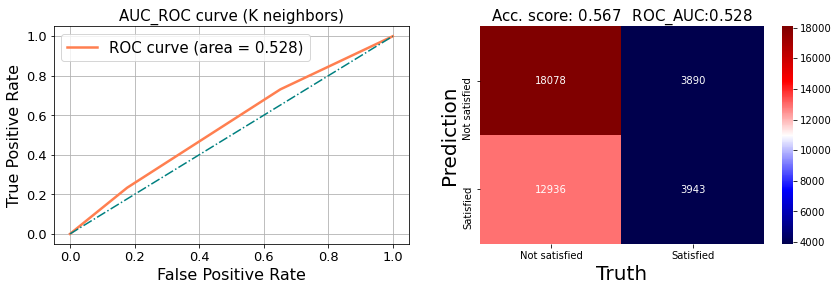

In [117]:
# Visualize the Confusion Matrix and check the accuracy score and ROC_AUC curve

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(fpr_Kmeans , tpr_Kmeans , color='coral', linewidth = 2.5, label="ROC curve (area = %0.3f)" % roc_auc_score_Kmeans)
axs[0].plot(fpr_Kmeans , fpr_Kmeans , linestyle='-.', color = 'teal')
axs[0].grid('on')
axs[0].set_ylabel('True Positive Rate', fontsize = 16)
axs[0].set_xlabel('False Positive Rate', fontsize = 16)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].set_title('AUC_ROC curve (K neighbors)', fontsize = 15)
axs[0].legend(fontsize = 15);

labX = ["Not satisfied", "Satisfied"]
sns.heatmap(cmatrix_Kmeans, annot=True, fmt="d", cmap="seismic", xticklabels = labX, yticklabels = labX)
plt.title('Acc. score: '+ str(np.round(acc_score_Kmeans,3))+ r'$\:\:$ ROC_AUC:'+ \
          str(np.round(roc_auc_score_Kmeans,3)), fontsize = 15);
plt.xlabel('Truth', fontsize = 20)
plt.ylabel('Prediction', fontsize = 20);

In [ ]:
'''
    As can be seen from the Confusion Matrix and AUC_ROC curve, K nearest neighbors has performed very badly 
    compared to Logistic Regression. The accuracy score was merely 0.528 compared to 0.859 for Logistic Regression.
    This was expected because K nearest neighbors lacks estimators and is not suited for large data sets, 
    as was the case here.
    
    In the next section, we will use Support Vector Machine (SVM) on the same training and test data sets and 
    compare the performance in terms of AUC_ROC curve and Accuracy score with Logistic Regression and K Nearest
    Neighbors.
''';

## SUPPORT VECTOR MACHINES (SVM)

C:\Users\debnathk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


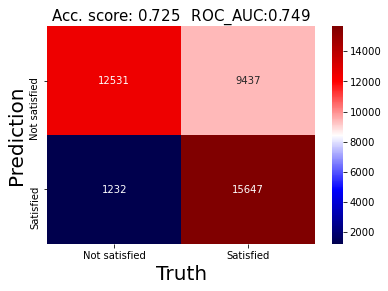

In [77]:
Y_pred_svm, acc_score_svm, roc_auc_score_svm, cmatrix_svm, fmodel_svm = _SVM(X_train, Y_train, X_test, Y_test)
# Visualize the Confusion Matrix

labX = ["Not satisfied", "Satisfied"]
sns.heatmap(cmatrix_svm, annot=True, fmt="d", cmap="seismic", xticklabels = labX, yticklabels = labX)
plt.title('Acc. score: '+ str(np.round(acc_score_svm,3))+ r'$\:\:$ ROC_AUC:'+ \
          str(np.round(roc_auc_score_svm,3)), fontsize = 15);
plt.xlabel('Truth', fontsize = 20)
plt.ylabel('Prediction', fontsize = 20);

In [112]:
'''

    In SVM there are atleast two options to explore- LinearSVM and SVC classifier with rbf function.
    However, the later is not suited for cases where the number of features and rows are large, which is
    the case for this dataset.
    
    We tried using SVC Classifier with rgf function and due to the size of the data set, it was nearly 
    impossible to finish the simulation. 
    
    In these cases, the recommended method is to transform the data set using Nystroem followed by using
    LinearSVC or SGDClassifier.
    
    However, it was becoming difficult to tune the hyperparameters alpha (for SGDClassifier) and gamma 
    (for Nystroem). 
    
    Hence we proceed next to use Decision Trees.


''';

## DECISION TREES

In [96]:
Y_pred_dt, acc_score_dt, roc_auc_score_dt, cmatrix_dt, fmodel_dt = _decisiontrees(X_train, Y_train, X_test, Y_test)
y_pred_proba = fmodel_dt.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_pred_proba)

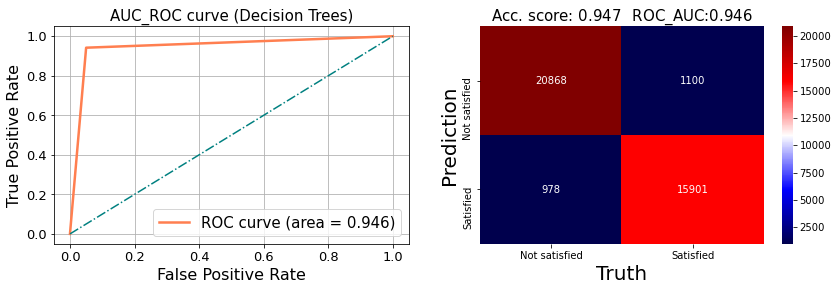

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(fpr_dt , tpr_dt , color='coral', linewidth = 2.5, label="ROC curve (area = %0.3f)" % roc_auc_score_dt)
axs[0].plot(fpr_dt , fpr_dt , linestyle='-.', color = 'teal')
axs[0].grid('on')
axs[0].set_ylabel('True Positive Rate', fontsize = 16)
axs[0].set_xlabel('False Positive Rate', fontsize = 16)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].tick_params(axis='y', labelsize=13)
axs[0].set_title('AUC_ROC curve (Decision Trees)', fontsize = 15)
axs[0].legend(fontsize = 15);

labX = ["Not satisfied", "Satisfied"]
sns.heatmap(cmatrix_dt, annot=True, fmt="d", cmap="seismic", xticklabels = labX, yticklabels = labX)
plt.title('Acc. score: '+ str(np.round(acc_score_dt,3))+ r'$\:\:$ ROC_AUC:'+ \
          str(np.round(roc_auc_score_dt,3)), fontsize = 15);
plt.xlabel('Truth', fontsize = 20)
plt.ylabel('Prediction', fontsize = 20);

## Summary of the analysis

In [119]:
print("SUMMARY of THE ANALYSIS-")
print("------------------------------------------------")

Dx = {'Logistic Regression':[acc_score_LR, roc_auc_score_LR],\
      'K nearest neigbors':[acc_score_Kmeans, roc_auc_score_Kmeans], 
      'Support Vector Machines (LinearSVC)':[acc_score_svm, roc_auc_score_svm], \
      'Decision Trees':[acc_score_dt, roc_auc_score_dt] }
Dx = pd.DataFrame(data=Dx).T
Dx.rename(columns={0: "Accuracy score", 1: "ROC_AUC score"})

SUMMARY of THE ANALYSIS-
------------------------------------------------


,Accuracy score,ROC_AUC score
Logistic Regression,0.859140,0.855966
K nearest neigbors,0.566865,0.528264
Support Vector Machines (LinearSVC),0.725358,0.748715
Decision Trees,0.946508,0.945993


### Clearly, for the given data set classification using Decision Trees has performed best with an accuracy score of 0.95 and ROC_AUC score of 0.94